In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

import datetime as dt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
ready = pd.read_csv('ready.csv')
ready

,Unnamed: 0,lat,lon,day,month,Labels
0,0,-6.270088,107.043609,25,9,True
1,1,-6.270088,107.043609,25,9,True
2,2,-6.270088,107.043609,25,9,True
3,3,-6.270088,107.043609,25,9,True
4,4,-6.270088,107.043609,25,9,True
...,...,...,...,...,...,...
3707443,3707443,-6.886813,107.581583,22,11,True
3707444,3707444,-6.886813,107.581583,22,11,True
3707445,3707445,-6.886813,107.581583,22,11,True
3707446,3707446,-6.886813,107.581583,22,11,True


In [3]:
ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707448 entries, 0 to 3707447
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   lat         float64
 2   lon         float64
 3   day         int64  
 4   month       int64  
 5   Labels      bool   
dtypes: bool(1), float64(2), int64(3)
memory usage: 145.0 MB


In [4]:
ready['x'] = np.cos(ready['lat']) * np.cos(ready['lon'])
ready['y'] = np.cos(ready['lat']) * np.sin(ready['lon'])
ready['z'] = np.sin(ready['lat'])

In [5]:
X = ready['x y z day month'.split()]
y = np.where(ready['Labels']==True,1,0)

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, random_state=24)

## LogisticRegression

In [7]:
lr_bal = LogisticRegression(class_weight='balanced', solver='liblinear')

In [8]:
skf = StratifiedKFold()
lr_bal_cv = cross_val_score(lr_bal, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [9]:
print('LogisticRegression score CV:', lr_bal_cv)
print('LogisticRegression score CV mean:', lr_bal_cv.mean())
print('LogisticRegression score CV std:', lr_bal_cv.std())

LogisticRegression score CV: [0.8082896  0.80893749 0.80507037 0.80899092 0.80950665]
LogisticRegression score CV mean: 0.8081590047166689
LogisticRegression score CV std: 0.0015919149312136934


## DecisionTreeClassifier

In [10]:
dtc = DecisionTreeClassifier()
dtc_cv = cross_val_score(dtc, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


In [11]:
print('DecisionTreeClassifier score CV:', dtc_cv)
print('DecisionTreeClassifier score CV mean:', dtc_cv.mean())
print('DecisionTreeClassifier score CV std:', dtc_cv.std())

DecisionTreeClassifier score CV: [0.99461097 0.99464311 0.99456712 0.99461038 0.99460529]
DecisionTreeClassifier score CV mean: 0.9946073741563618
DecisionTreeClassifier score CV std: 2.4181147461250605e-05


## Calibrated DTC

In [12]:
dtc = DecisionTreeClassifier()
dtc_cal = CalibratedClassifierCV(dtc, method='isotonic')
dtc_cal_cv = cross_val_score(dtc_cal, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 12.9min finished


In [13]:
print('DecisionTreeClassifier Calibrated score CV:', dtc_cal_cv)
print('DecisionTreeClassifier Calibrated score CV mean:', dtc_cal_cv.mean())
print('DecisionTreeClassifier Calibrated score CV std:', dtc_cal_cv.std())

DecisionTreeClassifier Calibrated score CV: [0.99461097 0.99464566 0.99456712 0.99461038 0.99460529]
DecisionTreeClassifier Calibrated score CV mean: 0.9946078850099633
DecisionTreeClassifier Calibrated score CV std: 2.494560188746837e-05


## LogisticRegression Polynomial

In [14]:
transformer = ColumnTransformer([
        ('poly', PolynomialFeatures(degree=2, include_bias=False), ['x','y','z'])
])

logit_pipe = Pipeline([
    ('trans', transformer),
    ('clf', LogisticRegression(random_state=2020))
])

In [15]:
logit_pipe_cv = cross_val_score(logit_pipe, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1, scoring='f1')
print('Logit Poly score CV:', logit_pipe_cv)
print('Logit Poly score CV mean:', logit_pipe_cv.mean())
print('Logit Poly score CV std:', logit_pipe_cv.std())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.1min finished


Logit Poly score CV: [0.98163113 0.98163203 0.98163203 0.98163203 0.9816311 ]
Logit Poly score CV mean: 0.9816316645806051
Logit Poly score CV std: 4.4867954700368715e-07


## KNeighborsClassifier
(Too heavy for my laptop)

In [16]:
X.head()

,x,y,z,day,month
0,0.973706,0.227431,0.013097,25,9
1,0.973706,0.227431,0.013097,25,9
2,0.973706,0.227431,0.013097,25,9
3,0.973706,0.227431,0.013097,25,9
4,0.973706,0.227431,0.013097,25,9


In [17]:
# knn = KNeighborsClassifier()

# scaler = ColumnTransformer([
#         ('scaler', StandardScaler(), ['x','y','z', 'day', 'month'])
# ])

# knn_pipe = Pipeline([
#     ('trans', transformer),
#     ('clf', knn)
# ])
# knn_cv = cross_val_score(knn_pipe, X_train_val, y_train_val, cv=skf, n_jobs=-1, verbose=1)

In [18]:
# print('KNN score CV:', knn_cv)
# print('KNN score CV mean:', knn_cv.mean())
# print('KNN score CV std:', knn_cv.std())

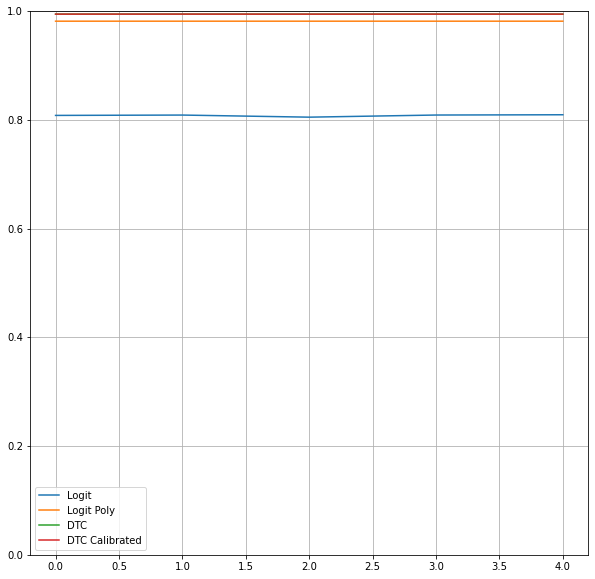

In [19]:
plt.figure(figsize=(10,10))
plt.plot(range(len(lr_bal_cv)), lr_bal_cv, label='Logit')
plt.plot(range(len(logit_pipe_cv)), logit_pipe_cv, label='Logit Poly')
plt.plot(range(len(dtc_cv)), dtc_cv, label='DTC')
plt.plot(range(len(dtc_cal_cv)), dtc_cal_cv, label='DTC Calibrated')
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.show()

In [20]:
dtc_cal.fit(X_train_val, y_train_val)
y_pred_dtc_cal = dtc_cal.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred_dtc_cal))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     33436
           1       1.00      0.99      0.99    893426

    accuracy                           0.99    926862
   macro avg       0.89      0.98      0.93    926862
weighted avg       0.99      0.99      0.99    926862

